## Group Project LLM

- r=2,4,8,16, epoch=10
- seed=42
- evaluation:
    - accuracy, f1, precision, recall
    - efficiency (time, trainable parameters, trainable paramters ratio, convergence)

In [36]:
import warnings
warnings.filterwarnings("default", module="__main__")
warnings.filterwarnings("ignore", module=".*")

### Base Model: DistilBERT

In [2]:
# ================== BASELINE DISTILBERT ================

import os, time, random
import numpy as np
import torch

from datasets import load_dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed
)
import evaluate


SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET = "stanfordnlp/sst2"
TEXT_COL = "sentence"
LABEL_COL = "label"
NUM_EPOCHS = 10
BATCH_SIZE = 16
LR = 2e-5

'''
for IMDB dataset:
DATASET = "imdb"
TEXT_COL = "text"
LABEL_COL = "label"
'''

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)

set_all_seeds(SEED)

# -------- Load dataset and split (8:1:1) --------
raw = load_dataset(DATASET)
train_full = raw["train"]

train_temp = train_full.train_test_split(test_size=0.2, seed=SEED)
train_ds = train_temp["train"]
temp = train_temp["test"]

val_test = temp.train_test_split(test_size=0.5, seed=SEED)
val_ds = val_test["train"]
test_ds = val_test["test"]


# -------- Tokenization --------
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
def preprocess(x):
    return tokenizer(x[TEXT_COL], truncation=True, max_length=128)

train_ds = train_ds.map(preprocess, batched=True)
val_ds   = val_ds.map(preprocess, batched=True)
test_ds  = test_ds.map(preprocess, batched=True)

train_ds = train_ds.rename_column(LABEL_COL, "labels")
val_ds   = val_ds.rename_column(LABEL_COL, "labels")
test_ds  = test_ds.rename_column(LABEL_COL, "labels")

cols = ["input_ids","attention_mask","labels"]
train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch", columns=cols)

collator = DataCollatorWithPadding(tokenizer)

# -------- Metrics --------
acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")
prec = evaluate.load("precision")
rec = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"],
        "precision": prec.compute(predictions=preds, references=labels, average="binary")["precision"],
        "recall": rec.compute(predictions=preds, references=labels, average="binary")["recall"],
    }

# -------- Model --------
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
ratio = trainable_params / total_params

print(f"Baseline: total={total_params}, trainable={trainable_params}, ratio={ratio:.4%}")

# -------- Train --------
args = TrainingArguments(
    output_dir="./baseline_distilbert",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=SEED,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

start = time.time()
trainer.train()
end = time.time()

print(f"Baseline training time: {end-start:.2f}s")
print("Eval:", trainer.evaluate(test_ds))
print("Convergence history:", trainer.state.log_history)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2836370/2350084452.py:110: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Baseline: total=66955010, trainable=66955010, ratio=100.0000%


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.238700,0.175075,0.941203,0.945409,0.943848,0.946976
2,0.125100,0.178515,0.944024,0.947704,0.952062,0.943386
3,0.088600,0.206909,0.944172,0.948521,0.940538,0.956642
4,0.061500,0.221665,0.944469,0.948385,0.947862,0.948909
5,0.047500,0.239832,0.947587,0.950979,0.956425,0.945595
6,0.033500,0.305291,0.945805,0.949759,0.946762,0.952775
7,0.027500,0.310512,0.946102,0.949966,0.948266,0.951671
8,0.018200,0.368410,0.946102,0.949924,0.949008,0.950842
9,0.012600,0.406172,0.946845,0.950580,0.950317,0.950842
10,0.010900,0.424868,0.946993,0.950670,0.951327,0.950014


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input ten

Baseline training time: 1624.58s


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval: {'eval_loss': 0.23587322235107422, 'eval_accuracy': 0.9452115812917594, 'eval_f1': 0.9513513513513514, 'eval_precision': 0.9504741833508957, 'eval_recall': 0.952230139878596, 'eval_runtime': 8.7337, 'eval_samples_per_second': 771.149, 'eval_steps_per_second': 24.159, 'epoch': 10.0}
Convergence history: [{'loss': 0.2387, 'grad_norm': 10.51264762878418, 'learning_rate': 1.800118764845606e-05, 'epoch': 1.0, 'step': 1684}, {'eval_loss': 0.17507508397102356, 'eval_accuracy': 0.9412026726057906, 'eval_f1': 0.9454094292803971, 'eval_precision': 0.9438480594549958, 'eval_recall': 0.9469759734879868, 'eval_runtime': 9.6709, 'eval_samples_per_second': 696.421, 'eval_steps_per_second': 21.818, 'epoch': 1.0, 'step': 1684}, {'loss': 0.1251, 'grad_norm': 5.240935325622559, 'learning_rate': 1.6001187648456057e-05, 'epoch': 2.0, 'step': 3368}, {'eval_loss': 0.1785149723291397, 'eval_accuracy': 0.9440237564959169, 'eval_f1': 0.9477042585656817, 'eval_precision': 0.9520624303232998, 'eval_recall':

In [10]:
import pandas as pd
# -------- Final Evaluation --------
final_metrics = trainer.evaluate(test_ds)

# -------- Save metrics --------
os.makedirs("./baseline_distilbert", exist_ok=True)
with open("./baseline_distilbert/final_metrics.json", "w") as f:
    json.dump(final_metrics, f, indent=4)

print("Saved final metrics to baseline_distilbert/final_metrics.json")

# -------- Save model --------
trainer.save_model("./baseline_distilbert/final_model")
print("Saved model to baseline_distilbert/final_model")

# -------- Convergence history --------
log_history = trainer.state.log_history
df_logs = pd.DataFrame(trainer.state.log_history)
# Separate clean tables
df_train = df_logs[df_logs["loss"].notnull()].reset_index(drop=True)
df_eval  = df_logs[df_logs["eval_loss"].notnull()].reset_index(drop=True)

df_train.to_csv("./baseline_distilbert/train_log.csv", index=False)
df_eval.to_csv("./baseline_distilbert/eval_log.csv", index=False)

/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Saved final metrics to baseline_distilbert/final_metrics.json
Saved model to baseline_distilbert/final_model


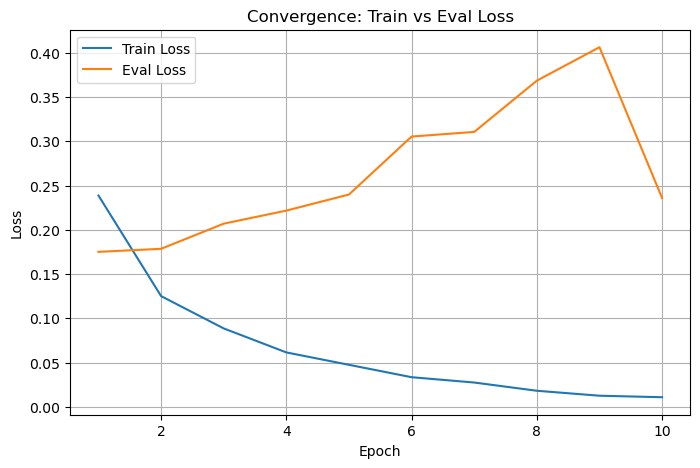

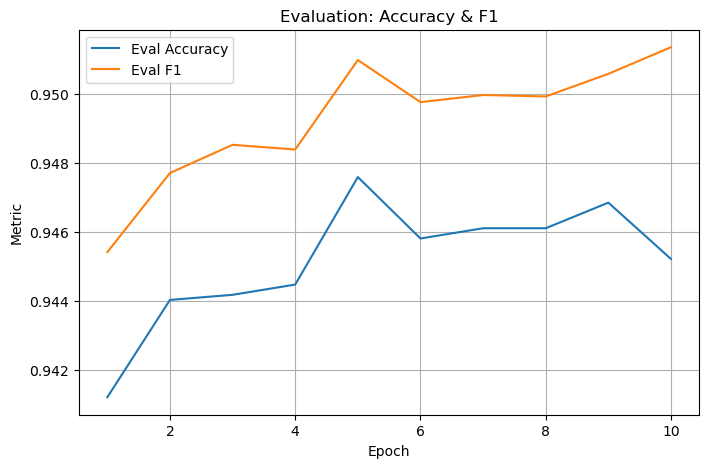

In [28]:
import matplotlib.pyplot as plt

df_eval_clean = df_eval.groupby("epoch").last().reset_index()

plt.figure(figsize=(8,5))
plt.plot(df_train["epoch"], df_train["loss"], label="Train Loss")
plt.plot(df_eval_clean["epoch"], df_eval_clean["eval_loss"], label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Convergence: Train vs Eval Loss")
plt.legend()
plt.grid()
plt.savefig("./baseline_distilbert/loss_curve.png", dpi=300)
plt.show()


plt.figure(figsize=(8,5))
plt.plot(df_eval_clean["epoch"], df_eval_clean["eval_accuracy"], label="Eval Accuracy")
plt.plot(df_eval_clean["epoch"], df_eval_clean["eval_f1"], label="Eval F1")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Evaluation: Accuracy & F1")
plt.legend()
plt.grid()
plt.savefig("./baseline_distilbert/metric_curve.png", dpi=300)
plt.show()

### Sparse LoRA

In [34]:
# ================== SPARSE LoRA MODEL =================

from typing import Dict, Any, List, Optional
import math
from peft import LoraConfig, get_peft_model

# -------- Sparse LoRA config --------
RANKS: List[int] = [2, 4, 8, 16]
L1_LAMBDA = 1e-5   # sparsity strength for LoRA weights


def count_trainable_params(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def count_total_params(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())


def compute_lora_sparsity(model: torch.nn.Module, threshold: float = 1e-3) -> float:
    """
    Approximate sparsity: fraction of LoRA parameters with |w| < threshold.
    """
    total = 0
    near_zero = 0
    for name, param in model.named_parameters():
        if "lora_" in name and param.requires_grad:
            data = param.detach().abs()
            total += data.numel()
            near_zero += (data < threshold).sum().item()
    return near_zero / total if total > 0 else math.nan


class SparseLoraTrainer(Trainer):
    """
    Trainer with L1 penalty only on LoRA parameters.
    """
    def __init__(self, l1_lambda: float = 0.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l1_lambda = l1_lambda

    def compute_loss(
        self,
        model,
        inputs,
        return_outputs: bool = False,
        num_items_in_batch: Optional[int] = None,  # NEW ARG
    ):
        # standard HF behavior
        outputs = model(**inputs)
        loss = outputs.loss

        # add L1 penalty on LoRA weights
        if self.l1_lambda > 0:
            l1_reg = 0.0
            for name, param in model.named_parameters():
                if "lora_" in name and param.requires_grad:
                    l1_reg = l1_reg + param.abs().sum()
            loss = loss + self.l1_lambda * l1_reg

        return (loss, outputs) if return_outputs else loss


results_per_rank: List[Dict[str, Any]] = []


for r in RANKS:
    print("\n" + "=" * 80)
    print(f"Training Sparse LoRA DistilBERT with rank = {r}, epochs = {NUM_EPOCHS}")
    print("=" * 80)

    set_all_seeds(SEED)

    # Base DistilBERT for this rank
    base_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2,
    )

    # LoRA config: attention projections in DistilBERT
    lora_config = LoraConfig(
        r=r,
        lora_alpha=2 * r,
        lora_dropout=0.1,
        bias="none",
        task_type="SEQ_CLS",    # sequence classification
        target_modules=["q_lin", "k_lin", "v_lin", "out_lin"],
    )

    lora_model = get_peft_model(base_model, lora_config)
    lora_model.to(DEVICE)

    total_params = count_total_params(lora_model)
    trainable_params = count_trainable_params(lora_model)
    param_ratio = trainable_params / total_params

    print(f"[Rank {r}] total params: {total_params:,}")
    print(f"[Rank {r}] trainable params: {trainable_params:,}")
    print(f"[Rank {r}] trainable params ratio (trainable / total): {param_ratio:.4%}")

    training_args_lora = TrainingArguments(
        output_dir=f"./sparse_lora_rank{r}",
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LR,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=SEED,
        report_to="none",
    )

    trainer = SparseLoraTrainer(
        l1_lambda=L1_LAMBDA,
        model=lora_model,
        args=training_args_lora,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    start_time = time.time()
    train_output = trainer.train()
    end_time = time.time()
    train_time = end_time - start_time
    print(f"[Rank {r}] Training time: {train_time:.2f} seconds")

    val_metrics = trainer.evaluate(eval_dataset=val_ds)
    test_metrics = trainer.evaluate(eval_dataset=test_ds)

    lora_sparsity = compute_lora_sparsity(lora_model, threshold=1e-3)
    print(f"[Rank {r}] Validation metrics: {val_metrics}")
    print(f"[Rank {r}] Test metrics: {test_metrics}")
    print(f"[Rank {r}] LoRA sparsity (<1e-3): {lora_sparsity:.2%}")
    print(f"[Rank {r}] Convergence log_history:")
    print(trainer.state.log_history)

    results_per_rank.append(
        {
            "rank": r,
            "total_params": total_params,
            "trainable_params": trainable_params,
            "param_ratio": param_ratio,
            "train_time_sec": train_time,
            "val_metrics": val_metrics,
            "test_metrics": test_metrics,
            "lora_sparsity(<1e-3)": lora_sparsity,
            "log_history": trainer.state.log_history,  # convergence
        }
    )

print("\n\n=== Summary over ranks (Sparse LoRA) ===")
for res in results_per_rank:
    r = res["rank"]
    print(f"\nRank {r}:")
    print(f"  Params: {res['trainable_params']:,} / {res['total_params']:,} "
          f"({res['param_ratio']:.2%})")
    print(f"  Train time: {res['train_time_sec']:.2f} s")
    print(f"  Val F1:  {res['val_metrics'].get('eval_f1', float('nan')):.4f}, "
          f"Acc: {res['val_metrics'].get('eval_accuracy', float('nan')):.4f}")
    print(f"  Test F1: {res['test_metrics'].get('eval_f1', float('nan')):.4f}, "
          f"Acc: {res['test_metrics'].get('eval_accuracy', float('nan')):.4f}")
    print(f"  LoRA sparsity (<1e-3): {res['lora_sparsity(<1e-3)']:.2%}")



Training Sparse LoRA DistilBERT with rank = 2, epochs = 10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Rank 2] total params: 67,620,868
[Rank 2] trainable params: 665,858
[Rank 2] trainable params ratio (trainable / total): 0.9847%


/tmp/ipykernel_2836370/731623691.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SparseLoraTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.393900,0.296121,0.876466,0.882320,0.904320,0.861364
2,0.316000,0.280038,0.885375,0.892867,0.897350,0.888429
3,0.302800,0.270784,0.891314,0.898951,0.898703,0.899199
4,0.292400,0.262972,0.894432,0.900989,0.908708,0.893400
5,0.285900,0.261988,0.896659,0.904422,0.899481,0.909417
6,0.281500,0.254590,0.897847,0.904205,0.911823,0.896714
7,0.277900,0.252679,0.899183,0.904995,0.917187,0.893123
8,0.275900,0.251038,0.899926,0.906957,0.906707,0.907208
9,0.272700,0.250182,0.900371,0.907231,0.908361,0.906103
10,0.271600,0.249398,0.900371,0.906793,0.912241,0.901408


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input ten

[Rank 2] Training time: 2040.75 seconds


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[Rank 2] Validation metrics: {'eval_loss': 0.25018182396888733, 'eval_accuracy': 0.9003711952487008, 'eval_f1': 0.9072307479607356, 'eval_precision': 0.9083610188261351, 'eval_recall': 0.9061032863849765, 'eval_runtime': 10.8933, 'eval_samples_per_second': 618.271, 'eval_steps_per_second': 19.37, 'epoch': 10.0}
[Rank 2] Test metrics: {'eval_loss': 0.26539742946624756, 'eval_accuracy': 0.8914625092798812, 'eval_f1': 0.9028313172936329, 'eval_precision': 0.9094804499196572, 'eval_recall': 0.8962787015043547, 'eval_runtime': 11.0689, 'eval_samples_per_second': 608.46, 'eval_steps_per_second': 19.062, 'epoch': 10.0}
[Rank 2] LoRA sparsity (<1e-3): 15.55%
[Rank 2] Convergence log_history:
[{'loss': 0.3939, 'grad_norm': 3.0737977027893066, 'learning_rate': 1.800118764845606e-05, 'epoch': 1.0, 'step': 1684}, {'eval_loss': 0.2961207926273346, 'eval_accuracy': 0.8764662212323683, 'eval_f1': 0.8823196605374823, 'eval_precision': 0.9043200927805161, 'eval_recall': 0.8613642640154653, 'eval_runtim

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Rank 4] total params: 67,694,596
[Rank 4] trainable params: 739,586
[Rank 4] trainable params ratio (trainable / total): 1.0925%


/tmp/ipykernel_2836370/731623691.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SparseLoraTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.386300,0.294177,0.879733,0.885915,0.903995,0.868545
2,0.312500,0.276367,0.890275,0.897801,0.899169,0.896437
3,0.298700,0.267596,0.894878,0.902399,0.900908,0.903894
4,0.287600,0.258988,0.899926,0.905761,0.917304,0.894504
5,0.280500,0.258202,0.902004,0.909564,0.902638,0.916598
6,0.275400,0.249693,0.904083,0.910103,0.917251,0.903065
7,0.271600,0.247551,0.905865,0.911477,0.921774,0.901408
8,0.268800,0.245857,0.906756,0.913451,0.911692,0.915217
9,0.265800,0.244966,0.906607,0.913062,0.913946,0.912179
10,0.265100,0.244083,0.907053,0.913152,0.917480,0.908865


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input ten

[Rank 4] Training time: 2031.34 seconds


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[Rank 4] Validation metrics: {'eval_loss': 0.245857372879982, 'eval_accuracy': 0.9067557535263548, 'eval_f1': 0.9134509371554576, 'eval_precision': 0.9116918844566713, 'eval_recall': 0.9152167909417288, 'eval_runtime': 11.4858, 'eval_samples_per_second': 586.376, 'eval_steps_per_second': 18.371, 'epoch': 10.0}
[Rank 4] Test metrics: {'eval_loss': 0.2627865672111511, 'eval_accuracy': 0.895025983667409, 'eval_f1': 0.9063948100092678, 'eval_precision': 0.9094048884165781, 'eval_recall': 0.9034045922406968, 'eval_runtime': 11.0578, 'eval_samples_per_second': 609.073, 'eval_steps_per_second': 19.082, 'epoch': 10.0}
[Rank 4] LoRA sparsity (<1e-3): 21.52%
[Rank 4] Convergence log_history:
[{'loss': 0.3863, 'grad_norm': 3.1279044151306152, 'learning_rate': 1.800118764845606e-05, 'epoch': 1.0, 'step': 1684}, {'eval_loss': 0.2941770851612091, 'eval_accuracy': 0.8797327394209354, 'eval_f1': 0.8859154929577465, 'eval_precision': 0.9039954009772924, 'eval_recall': 0.8685446009389671, 'eval_runtime'

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2836370/731623691.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SparseLoraTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


[Rank 8] total params: 67,842,052
[Rank 8] trainable params: 887,042
[Rank 8] trainable params ratio (trainable / total): 1.3075%


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.386200,0.295880,0.884781,0.891134,0.905617,0.877106
2,0.313800,0.277604,0.894878,0.902237,0.902237,0.902237
3,0.299300,0.268710,0.897847,0.905546,0.900355,0.910798
4,0.287800,0.259213,0.904826,0.910362,0.922096,0.898923
5,0.280200,0.259396,0.904380,0.912094,0.901754,0.922673
6,0.273700,0.249641,0.908389,0.914222,0.920493,0.908036
7,0.269600,0.247296,0.911359,0.916468,0.928815,0.904446
8,0.266700,0.245347,0.910171,0.916632,0.914741,0.918531
9,0.263500,0.244415,0.911210,0.917220,0.919512,0.914941
10,0.262700,0.243555,0.912101,0.917823,0.922690,0.913007


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input ten

[Rank 8] Training time: 2055.44 seconds


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[Rank 8] Validation metrics: {'eval_loss': 0.24355515837669373, 'eval_accuracy': 0.9121009651076466, 'eval_f1': 0.917823431426985, 'eval_precision': 0.9226904828356126, 'eval_recall': 0.9130074565037283, 'eval_runtime': 11.4322, 'eval_samples_per_second': 589.124, 'eval_steps_per_second': 18.457, 'epoch': 10.0}
[Rank 8] Test metrics: {'eval_loss': 0.25989142060279846, 'eval_accuracy': 0.9017074981440237, 'eval_f1': 0.9122015915119364, 'eval_precision': 0.9168221807517996, 'eval_recall': 0.9076273423066772, 'eval_runtime': 11.906, 'eval_samples_per_second': 565.682, 'eval_steps_per_second': 17.722, 'epoch': 10.0}
[Rank 8] LoRA sparsity (<1e-3): 27.88%
[Rank 8] Convergence log_history:
[{'loss': 0.3862, 'grad_norm': 2.9998624324798584, 'learning_rate': 1.800118764845606e-05, 'epoch': 1.0, 'step': 1684}, {'eval_loss': 0.2958800792694092, 'eval_accuracy': 0.8847809948032666, 'eval_f1': 0.8911335578002245, 'eval_precision': 0.9056173367550613, 'eval_recall': 0.8771057718862193, 'eval_runtim

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2836370/731623691.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SparseLoraTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


[Rank 16] total params: 68,136,964
[Rank 16] trainable params: 1,181,954
[Rank 16] trainable params ratio (trainable / total): 1.7347%


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.397100,0.309513,0.889087,0.895363,0.908471,0.882629
2,0.324600,0.288913,0.897996,0.905228,0.904355,0.906103
3,0.307300,0.277806,0.905419,0.912368,0.908991,0.915769
4,0.294300,0.267853,0.910022,0.914864,0.931084,0.899199
5,0.284800,0.267210,0.910022,0.916872,0.910875,0.922949
6,0.277500,0.257248,0.913289,0.918731,0.925947,0.911627
7,0.272300,0.254617,0.915516,0.920319,0.933523,0.907484
8,0.268700,0.252295,0.915071,0.920885,0.922416,0.919359
9,0.265500,0.251517,0.917001,0.922393,0.927415,0.917426
10,0.263500,0.250823,0.916852,0.922092,0.929072,0.915217


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input ten

[Rank 16] Training time: 2037.07 seconds


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/hpc/group/yizhanglab/yh151/miniconda3/envs/my-conda-env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[Rank 16] Validation metrics: {'eval_loss': 0.25151702761650085, 'eval_accuracy': 0.9170007423904974, 'eval_f1': 0.9223934471747883, 'eval_precision': 0.9274148520379676, 'eval_recall': 0.9174261253797293, 'eval_runtime': 11.2976, 'eval_samples_per_second': 596.147, 'eval_steps_per_second': 18.677, 'epoch': 10.0}
[Rank 16] Test metrics: {'eval_loss': 0.2650555968284607, 'eval_accuracy': 0.9097253155159614, 'eval_f1': 0.9195128408790045, 'eval_precision': 0.9224435590969455, 'eval_recall': 0.9166006861968857, 'eval_runtime': 12.1809, 'eval_samples_per_second': 552.916, 'eval_steps_per_second': 17.322, 'epoch': 10.0}
[Rank 16] LoRA sparsity (<1e-3): 35.68%
[Rank 16] Convergence log_history:
[{'loss': 0.3971, 'grad_norm': 3.299694776535034, 'learning_rate': 1.800118764845606e-05, 'epoch': 1.0, 'step': 1684}, {'eval_loss': 0.3095133304595947, 'eval_accuracy': 0.889086859688196, 'eval_f1': 0.8953634962879955, 'eval_precision': 0.908470722001137, 'eval_recall': 0.8826291079812206, 'eval_runt

In [39]:
# ================== SPARSE LoRA MODEL =================

from typing import Dict, Any, List, Optional
import math
from peft import LoraConfig, get_peft_model

# -------- Sparse LoRA config --------
RANKS: List[int] = [2, 4, 8, 16]
L1_LAMBDA = 1e-5   # sparsity strength for LoRA weights


def count_trainable_params(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def count_total_params(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())


def compute_lora_sparsity(model: torch.nn.Module, threshold: float = 1e-3) -> float:
    """
    Approximate sparsity: fraction of LoRA parameters with |w| < threshold.
    """
    total = 0
    near_zero = 0
    for name, param in model.named_parameters():
        if "lora_" in name and param.requires_grad:
            data = param.detach().abs()
            total += data.numel()
            near_zero += (data < threshold).sum().item()
    return near_zero / total if total > 0 else math.nan


class SparseLoraTrainer(Trainer):
    """
    Trainer with L1 penalty only on LoRA parameters.
    """
    def __init__(self, l1_lambda: float = 0.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l1_lambda = l1_lambda

    def compute_loss(
        self,
        model,
        inputs,
        return_outputs: bool = False,
        num_items_in_batch: Optional[int] = None,
    ):
        outputs = model(**inputs)
        loss = outputs.loss

        if self.l1_lambda > 0:
            l1_reg = 0.0
            for name, param in model.named_parameters():
                if "lora_" in name and param.requires_grad:
                    l1_reg = l1_reg + param.abs().sum()
            loss = loss + self.l1_lambda * l1_reg

        return (loss, outputs) if return_outputs else loss


results_per_rank: List[Dict[str, Any]] = []

for r in RANKS:
    print("\n" + "=" * 80)
    print(f"Training Sparse LoRA DistilBERT with rank = {r}, epochs = {NUM_EPOCHS}")
    print("=" * 80)

    set_all_seeds(SEED)

    # Base DistilBERT for this rank
    base_model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2,
    )

    # LoRA config: attention projections in DistilBERT
    lora_config = LoraConfig(
        r=r,
        lora_alpha=2 * r,
        lora_dropout=0.1,
        bias="none",
        task_type="SEQ_CLS",    # sequence classification
        target_modules=["q_lin", "k_lin", "v_lin", "out_lin"],
    )

    lora_model = get_peft_model(base_model, lora_config)
    lora_model.to(DEVICE)

    total_params = count_total_params(lora_model)
    trainable_params = count_trainable_params(lora_model)
    param_ratio = trainable_params / total_params

    print(f"[Rank {r}] total params: {total_params:,}")
    print(f"[Rank {r}] trainable params: {trainable_params:,}")
    print(f"[Rank {r}] trainable params ratio (trainable / total): {param_ratio:.4%}")

    output_dir = f"./sparse_lora_rank{r}"
    os.makedirs(output_dir, exist_ok=True)

    training_args_lora = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LR,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=SEED,
        report_to="none",
    )

    trainer = SparseLoraTrainer(
        l1_lambda=L1_LAMBDA,
        model=lora_model,
        args=training_args_lora,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    start_time = time.time()
    trainer.train()
    end_time = time.time()
    train_time = end_time - start_time
    print(f"[Rank {r}] Training time: {train_time:.2f} seconds")

    # --- final evals ---
    val_metrics = trainer.evaluate(eval_dataset=val_ds)
    test_metrics = trainer.evaluate(eval_dataset=test_ds)
    lora_sparsity = compute_lora_sparsity(lora_model, threshold=1e-3)

    print(f"[Rank {r}] Validation metrics: {val_metrics}")
    print(f"[Rank {r}] Test metrics: {test_metrics}")
    print(f"[Rank {r}] LoRA sparsity (<1e-3): {lora_sparsity:.2%}")

    # ==========================
    # SAVE METRICS / MODEL / LOG
    # ==========================
    # 1) save metrics
    metrics_payload = {
        "rank": r,
        "train_time_sec": train_time,
        "total_params": int(total_params),
        "trainable_params": int(trainable_params),
        "param_ratio": float(param_ratio),
        "lora_sparsity_<1e-3": float(lora_sparsity),
        "val_metrics": val_metrics,
        "test_metrics": test_metrics,
    }
    with open(os.path.join(output_dir, "final_metrics.json"), "w") as f:
        json.dump(metrics_payload, f, indent=4)

    # 2) save final model (best checkpoint)
    final_model_dir = os.path.join(output_dir, "final_model")
    trainer.save_model(final_model_dir)  # saves model + config
    tokenizer.save_pretrained(final_model_dir)  # save tokenizer too
    print(f"[Rank {r}] Saved model to {final_model_dir}")

    # 3) save convergence history
    log_history = trainer.state.log_history
    with open(os.path.join(output_dir, "log_history.json"), "w") as f:
        json.dump(log_history, f, indent=4)
    print(f"[Rank {r}] Saved log history to log_history.json")

    # --- store in-memory summary for printing ---
    results_per_rank.append(
        {
            "rank": r,
            "total_params": total_params,
            "trainable_params": trainable_params,
            "param_ratio": param_ratio,
            "train_time_sec": train_time,
            "val_metrics": val_metrics,
            "test_metrics": test_metrics,
            "lora_sparsity(<1e-3)": lora_sparsity,
        }
    )

print("\n\n=== Summary over ranks (Sparse LoRA) ===")
for res in results_per_rank:
    r = res["rank"]
    print(f"\nRank {r}:")
    print(f"  Params: {res['trainable_params']:,} / {res['total_params']:,} "
          f"({res['param_ratio']:.2%})")
    print(f"  Train time: {res['train_time_sec']:.2f} s")
    print(f"  Val F1:  {res['val_metrics'].get('eval_f1', float('nan')):.4f}, "
          f"Acc: {res['val_metrics'].get('eval_accuracy', float('nan')):.4f}")
    print(f"  Test F1: {res['test_metrics'].get('eval_f1', float('nan')):.4f}, "
          f"Acc: {res['test_metrics'].get('eval_accuracy', float('nan')):.4f}")
    print(f"  LoRA sparsity (<1e-3): {res['lora_sparsity(<1e-3)']:.2%}")


Training Sparse LoRA DistilBERT with rank = 2, epochs = 10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Rank 2] total params: 67,620,868
[Rank 2] trainable params: 665,858
[Rank 2] trainable params ratio (trainable / total): 0.9847%


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.393900,0.296121,0.876466,0.882320,0.904320,0.861364
2,0.316000,0.280038,0.885375,0.892867,0.897350,0.888429
3,0.302800,0.270784,0.891314,0.898951,0.898703,0.899199
4,0.292400,0.262972,0.894432,0.900989,0.908708,0.893400
5,0.285900,0.261988,0.896659,0.904422,0.899481,0.909417
6,0.281500,0.254590,0.897847,0.904205,0.911823,0.896714
7,0.277900,0.252679,0.899183,0.904995,0.917187,0.893123
8,0.275900,0.251038,0.899926,0.906957,0.906707,0.907208
9,0.272700,0.250182,0.900371,0.907231,0.908361,0.906103
10,0.271600,0.249398,0.900371,0.906793,0.912241,0.901408


[Rank 2] Training time: 2000.22 seconds


[Rank 2] Validation metrics: {'eval_loss': 0.25018182396888733, 'eval_accuracy': 0.9003711952487008, 'eval_f1': 0.9072307479607356, 'eval_precision': 0.9083610188261351, 'eval_recall': 0.9061032863849765, 'eval_runtime': 11.2932, 'eval_samples_per_second': 596.375, 'eval_steps_per_second': 18.684, 'epoch': 10.0}
[Rank 2] Test metrics: {'eval_loss': 0.26539742946624756, 'eval_accuracy': 0.8914625092798812, 'eval_f1': 0.9028313172936329, 'eval_precision': 0.9094804499196572, 'eval_recall': 0.8962787015043547, 'eval_runtime': 10.8577, 'eval_samples_per_second': 620.299, 'eval_steps_per_second': 19.433, 'epoch': 10.0}
[Rank 2] LoRA sparsity (<1e-3): 15.55%
[Rank 2] Saved model to ./sparse_lora_rank2/final_model
[Rank 2] Saved log history to log_history.json

Training Sparse LoRA DistilBERT with rank = 4, epochs = 10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Rank 4] total params: 67,694,596
[Rank 4] trainable params: 739,586
[Rank 4] trainable params ratio (trainable / total): 1.0925%


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.386300,0.294177,0.879733,0.885915,0.903995,0.868545
2,0.312500,0.276367,0.890275,0.897801,0.899169,0.896437
3,0.298700,0.267596,0.894878,0.902399,0.900908,0.903894
4,0.287600,0.258988,0.899926,0.905761,0.917304,0.894504
5,0.280500,0.258202,0.902004,0.909564,0.902638,0.916598
6,0.275400,0.249693,0.904083,0.910103,0.917251,0.903065
7,0.271600,0.247551,0.905865,0.911477,0.921774,0.901408
8,0.268800,0.245857,0.906756,0.913451,0.911692,0.915217
9,0.265800,0.244966,0.906607,0.913062,0.913946,0.912179
10,0.265100,0.244083,0.907053,0.913152,0.917480,0.908865


[Rank 4] Training time: 2051.59 seconds


[Rank 4] Validation metrics: {'eval_loss': 0.245857372879982, 'eval_accuracy': 0.9067557535263548, 'eval_f1': 0.9134509371554576, 'eval_precision': 0.9116918844566713, 'eval_recall': 0.9152167909417288, 'eval_runtime': 11.4603, 'eval_samples_per_second': 587.683, 'eval_steps_per_second': 18.411, 'epoch': 10.0}
[Rank 4] Test metrics: {'eval_loss': 0.2627865672111511, 'eval_accuracy': 0.895025983667409, 'eval_f1': 0.9063948100092678, 'eval_precision': 0.9094048884165781, 'eval_recall': 0.9034045922406968, 'eval_runtime': 11.9928, 'eval_samples_per_second': 561.588, 'eval_steps_per_second': 17.594, 'epoch': 10.0}
[Rank 4] LoRA sparsity (<1e-3): 21.52%
[Rank 4] Saved model to ./sparse_lora_rank4/final_model
[Rank 4] Saved log history to log_history.json

Training Sparse LoRA DistilBERT with rank = 8, epochs = 10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Rank 8] total params: 67,842,052
[Rank 8] trainable params: 887,042
[Rank 8] trainable params ratio (trainable / total): 1.3075%


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.386200,0.295880,0.884781,0.891134,0.905617,0.877106
2,0.313800,0.277604,0.894878,0.902237,0.902237,0.902237
3,0.299300,0.268710,0.897847,0.905546,0.900355,0.910798
4,0.287800,0.259213,0.904826,0.910362,0.922096,0.898923
5,0.280200,0.259396,0.904380,0.912094,0.901754,0.922673
6,0.273700,0.249641,0.908389,0.914222,0.920493,0.908036
7,0.269600,0.247296,0.911359,0.916468,0.928815,0.904446
8,0.266700,0.245347,0.910171,0.916632,0.914741,0.918531
9,0.263500,0.244415,0.911210,0.917220,0.919512,0.914941
10,0.262700,0.243555,0.912101,0.917823,0.922690,0.913007


[Rank 8] Training time: 2036.44 seconds


[Rank 8] Validation metrics: {'eval_loss': 0.24355515837669373, 'eval_accuracy': 0.9121009651076466, 'eval_f1': 0.917823431426985, 'eval_precision': 0.9226904828356126, 'eval_recall': 0.9130074565037283, 'eval_runtime': 11.7129, 'eval_samples_per_second': 575.007, 'eval_steps_per_second': 18.014, 'epoch': 10.0}
[Rank 8] Test metrics: {'eval_loss': 0.25989142060279846, 'eval_accuracy': 0.9017074981440237, 'eval_f1': 0.9122015915119364, 'eval_precision': 0.9168221807517996, 'eval_recall': 0.9076273423066772, 'eval_runtime': 11.2317, 'eval_samples_per_second': 599.641, 'eval_steps_per_second': 18.786, 'epoch': 10.0}
[Rank 8] LoRA sparsity (<1e-3): 27.88%
[Rank 8] Saved model to ./sparse_lora_rank8/final_model
[Rank 8] Saved log history to log_history.json

Training Sparse LoRA DistilBERT with rank = 16, epochs = 10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Rank 16] total params: 68,136,964
[Rank 16] trainable params: 1,181,954
[Rank 16] trainable params ratio (trainable / total): 1.7347%


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.397100,0.309513,0.889087,0.895363,0.908471,0.882629
2,0.324600,0.288913,0.897996,0.905228,0.904355,0.906103
3,0.307300,0.277806,0.905419,0.912368,0.908991,0.915769
4,0.294300,0.267853,0.910022,0.914864,0.931084,0.899199
5,0.284800,0.267210,0.910022,0.916872,0.910875,0.922949
6,0.277500,0.257248,0.913289,0.918731,0.925947,0.911627
7,0.272300,0.254617,0.915516,0.920319,0.933523,0.907484
8,0.268700,0.252295,0.915071,0.920885,0.922416,0.919359
9,0.265500,0.251517,0.917001,0.922393,0.927415,0.917426
10,0.263500,0.250823,0.916852,0.922092,0.929072,0.915217


[Rank 16] Training time: 2026.30 seconds


[Rank 16] Validation metrics: {'eval_loss': 0.25151702761650085, 'eval_accuracy': 0.9170007423904974, 'eval_f1': 0.9223934471747883, 'eval_precision': 0.9274148520379676, 'eval_recall': 0.9174261253797293, 'eval_runtime': 11.2259, 'eval_samples_per_second': 599.952, 'eval_steps_per_second': 18.796, 'epoch': 10.0}
[Rank 16] Test metrics: {'eval_loss': 0.2650555968284607, 'eval_accuracy': 0.9097253155159614, 'eval_f1': 0.9195128408790045, 'eval_precision': 0.9224435590969455, 'eval_recall': 0.9166006861968857, 'eval_runtime': 10.8663, 'eval_samples_per_second': 619.804, 'eval_steps_per_second': 19.418, 'epoch': 10.0}
[Rank 16] LoRA sparsity (<1e-3): 35.68%
[Rank 16] Saved model to ./sparse_lora_rank16/final_model
[Rank 16] Saved log history to log_history.json


=== Summary over ranks (Sparse LoRA) ===

Rank 2:
  Params: 665,858 / 67,620,868 (0.98%)
  Train time: 2000.22 s
  Val F1:  0.9072, Acc: 0.9004
  Test F1: 0.9028, Acc: 0.8915
  LoRA sparsity (<1e-3): 15.55%

Rank 4:
  Params: 739

### IMDB Dataset

Have commented out in the corresponding section \
Just to replace the loaded dataset accordingly:
- DATASET = "imdb"
- TEXT_COL = "text"
- LABEL_COL = "label"